## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [62]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [63]:
df = pd.read_csv('./ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [64]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [65]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [66]:
sum(df.converted)/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [67]:
sum([df.query("group == 'control' and landing_page == 'new_page'").shape[0],
     df.query("group == 'treatment' and landing_page == 'old_page'").shape[0]])

3893

f. Do any of the rows have missing values?

In [68]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [69]:
df2 = pd.concat([df.query("group == 'control' and landing_page == 'old_page'"),df.query("group == 'treatment' and landing_page == 'new_page'")])

In [70]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [71]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [72]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [73]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [74]:
df2 = df2[df2.user_id.duplicated() == False]

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [75]:
sum(df2.converted)/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [76]:
control_df = df2.query('group == "control"')
sum(control_df.converted)/control_df.shape[0]

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [77]:
treatment_df = df2.query("group == 'treatment'")
sum(treatment_df.converted)/treatment_df.shape[0]

0.11880806551510564

d. What is the probability that an individual received the new page?

In [78]:
df2.landing_page.value_counts()['new_page']/df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

From the results above we know that every person has 50% probabiilty of getting both new page and landing page. Yet Probability of converting is almost same for both new_page and old_page. so there's no proof that new page is better than old page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$** : **$p_{old}$** >= **$p_{new}$**

**$H_{1}$** : **$p_{old}$** < **$p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [79]:
p_new = sum(df2.converted)/df2.shape[0]
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [80]:
p_old = sum(df2.converted)/df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$?

In [81]:
n_new = treatment_df.user_id.nunique()
n_new

145310

d. What is $n_{old}$?

In [82]:
n_old = control_df.user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [83]:
new_page_converted = np.random.binomial(n_new, p_new,  10000)/n_new
new_page_converted

array([0.11814053, 0.12039777, 0.11984034, ..., 0.11968206, 0.12023261,
       0.12021884])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [84]:
old_page_converted = np.random.binomial(n_old,p_old ,10000)/n_old
old_page_converted

array([0.11984939, 0.12102647, 0.11957405, ..., 0.12024175, 0.11870672,
       0.120345  ])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [85]:
p_diffs = new_page_converted - old_page_converted

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [86]:
p_diffs = new_page_converted - old_page_converted

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([  19.,  122.,  549., 1567., 2625., 2781., 1559.,  618.,  141.,
          19.]),
 array([-4.38643681e-03, -3.51369703e-03, -2.64095725e-03, -1.76821747e-03,
        -8.95477693e-04, -2.27379131e-05,  8.50001866e-04,  1.72274165e-03,
         2.59548143e-03,  3.46822121e-03,  4.34096098e-03]),
 <a list of 10 Patch objects>)

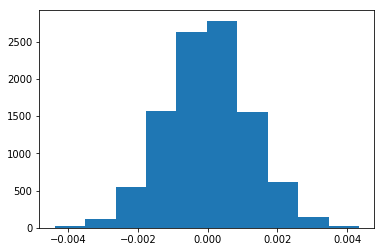

In [87]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [88]:
old = control_df[control_df.converted == 1].user_id.nunique()/control_df.user_id.nunique()
new = treatment_df[treatment_df.converted == 1].user_id.nunique()/treatment_df.user_id.nunique()

obs_diff = new-old

In [89]:
(p_diffs > obs_diff).mean()

0.9085

we got our p value 0.904 , since is more than 90% we fail to reject our null hypothesis and we should say that we should keep the old page for our web site.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [90]:
import statsmodels.api as sm

convert_old = sum((df2.group == 'control') & (df2.converted == 1)) 
convert_new = sum((df2.group == 'treatment') & (df2.converted == 1)) 
n_old = sum(df2.group == 'control') 
n_new = sum(df2.group == 'treatment') 

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [91]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger') 
z_score,p_value

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

Since the computed p-values is almost same as the p-value in j , we can say that we fail to reject null hypothesis and we should keep the old page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [92]:
df3 = df2.copy()
df3['intercept'] = 1
df3[['new_page','old_page']] = pd.get_dummies(df3.landing_page)
df3.head(10)

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,1
15,644214,2017-01-22 02:05:21.719434,control,old_page,1,1,0,1
16,847721,2017-01-17 14:01:00.090575,control,old_page,0,1,0,1
18,650559,2017-01-24 11:55:51.084801,control,old_page,0,1,0,1
19,935734,2017-01-17 20:33:37.428378,control,old_page,0,1,0,1
25,746742,2017-01-23 11:38:29.592148,control,old_page,0,1,0,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [93]:
import statsmodels.api as sm

mod = sm.Logit(df3['converted'],df3[['intercept','old_page',]])
fit = mod.fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 08 Jul 2019   Pseudo R-squ.:               8.077e-06
Time:                        15:44:01   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
old_page       0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

Since we're using Logistic Regression we need to exponantiate the `coef` values in order to interpret the results.

In [94]:
np.exp(0.0150)

1.015113064615719

+ The value we recieved is multiplicative change in the odds. 

+ We chose `old_page` as our regression variable, That means we have our proof that person receiving `old_page` has 1.015 times likely chance of converting compared to `new_page`

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

+ `p-value` aasosiated with Logistic Regression is 0.190 for group variable and it is different from Part I because of two different hypothesis.
<br>

+ In out first part our `Null Hypothesis` and `Alternate Hypothesis` were **$H_{0}$** : **$p_{old}$** >= **$p_{new}$** `and` **$H_{1}$** : **$p_{old}$** < **$p_{new}$** respectivly.
<br>

+ But in Logistic Regression Part our `Null Hypothesis` is **$H_{0} = 0 $** and our `Alternate Hypothesis` is **$H_{1} = 1$** so it's no big deal that `p-values` from both parts differ.
<br>


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

+ Since we are runnig the test for an e-commerce website there are a lots of fatctors to consider instead of using only control-treatment.
<br>

+ While buying products online not only look of the website but photos of product , provided description and reviews also matter. 
<br>

+ We have countries dataset available for current project so we'll use it and dive deeper in the factors that helps us selling products.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [95]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0


In [96]:
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [97]:
### Create the necessary dummy variables
df_new[['CA','UK','US']] = pd.get_dummies(df_new.country)
df_new['intercept'] = 1
df_new.head()

,country,timestamp,group,landing_page,converted,CA,UK,US,intercept
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [98]:
### Fit Your Linear Model And Obtain the Results
import statsmodels.api as sm

lin = sm.Logit(df_new.converted,df_new[['intercept','UK','US',]])
mod = lin.fit()
mod.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 08 Jul 2019   Pseudo R-squ.:               1.521e-05
Time:                        15:44:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

+ We used `Logistic Regression` for our final test so we are goint to exponantiate values to interpret the results.

In [99]:
np.exp(0.0507),np.exp(0.0408),np.exp(0.0507)/np.exp(0.0408)

(1.052007243765014, 1.0416437559600236, 1.009949167117542)

+ From results above we can say that person from has 1.05 times likely chances to get converted compared to a person from CA and same goes for person from US with 1.041 percent.
<br>

+ If we take CA as base and compare UK and US , a person from UK has 1.009 times likely chances to get converted compared to person from US.

<a id='conclusions'></a>
## Conclusions


> We went through the probability,A/B and regression analysis and interpreted the results to find out what is statstically significant for our website. 

>Firstly we ran tests using click trough rate as our metric to find out which page is good for a better [conversion rate](https://www.optimizely.com/optimization-glossary/conversion-rate/).

> Throughout test we found out that old_page is more statstifically significant compared to new_page and we should keep the old page for the sake of the website.

> We also added new variable `country` to find out whether user's geological location effects the click through rate or not. We found out that user's from UK are prone to convert more regardless of he is recieving old page or new page. 